<a href="https://colab.research.google.com/github/brunoodon/mvp_sprintII/blob/main/MVP_SprintII(B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics - Sprint II(B)
### Bruno Odon

# Descrição do problema



É um problema de Classificação, onde o objetivo é ter um modelo preditivo que consiga classificar imagens de instrumentos musicais segundo suas catregorias.

## Descrição do dataset:

Este dataset é criado a partir de um banco de imagens de instrumentos musicais a venda.

**Seguem os campos:**

images: o nome do arquivo de imagem

class: o rótulo aplicado a cada imagem

height: altura da imagem

width: largura da imagem

channels: quantidade de canais da imagem

filesize: tamanho do arquivo.





# Preparação dos dados

Primeiramente, vamos instalar e importar as bibliotecas necessárias para o projeto.

In [74]:
!pip install tensorflow
!pip install keras

In [75]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as skm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
import os
from sklearn.model_selection import train_test_split
import shutil
import random
import math
import numpy as np
import zipfile
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import matplotlib.pyplot as plt

In [54]:
!mkdir -pv datasets/music
!wget 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music.zip' -P datasets/

--2023-07-20 21:07:02--  https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10632185 (10M) [application/zip]
Saving to: ‘datasets/music.zip.9’

music.zip.9         100%[===================>]  10.14M  --.-KB/s    in 0.1s    

2023-07-20 21:07:02 (93.4 MB/s) - ‘datasets/music.zip.9’ saved [10632185/10632185]



In [55]:
import zipfile
dataset = 'datasets/music.zip'
dest = 'datasets/music/'
with zipfile.ZipFile(dataset,'r') as zip_ref:
  zip_ref.extractall(dest)

In [56]:
#verificando o número de imagens que foram extraídas
path='datasets/music/'
print(f"Temos um total de {len(os.listdir(path))} imagens em nosso dataset")

#exemplos de algumas imagens extraídas
print(f"Primeiras 20 imagens: \n {os.listdir(path)[:20]}")


Temos um total de 2596 imagens em nosso dataset
Primeiras 20 imagens: 
 ['1634117972100_Guitar Back Amp with Powered Pa System for sale.jpg', '1634112498970_BOYA BYWHM8 Pro Wireless Handheld Microphone for sale.jpg', '1634112358159_Pioneer EFX500 DJ Effects ControllerJAPAN for sale.jpg', '1634118001273_Boya M1DM Dual Mic for sale.jpg', '1634111157863_YAMAHA Piano for sale.jpg', '1634112841166_Dj Light Stand for sale.jpg', '1634112920947_Guitar for sale.jpg', '1634110584381_Electric Guitar for sale.jpg', '1634117638438_Fiber Dholky for sale.jpg', '1634117578620_Cashio organ for sale.jpg', '1634117867993_Pro instrument cable for sale.jpg', '1634109704493_Saxaphone  Soprano for sale.jpg', '1634110189621_YAMAHA FX900 SIMULEFFECT PROCESSOR for sale.jpg', '1634112802198_Japan Amplifier for sale.jpg', '1634110386536_Professional Studio Recording Microphone Stand Small for sale.jpg', '1634112801953_DJ System for sale.jpg', '1634112953454_Warwick Rockbass Streamer lx 5 Bass Guitar for sale.jpg'

In [64]:
from sklearn.preprocessing import FunctionTransformer
import re
#Criando um DataFrame com as informações das imagens

images = os.listdir(path)
labels, heights, widths, channels, filesize, files = [], [], [], [], [], []

# Loop que percorre cada uma das imagens extraídas
guitar_count=0
for fname in images:
    try:
      def file_settings():
          img_shape = mpimg.imread(path+fname).shape
          heights.append(img_shape[0])
          widths.append(img_shape[1])
          channels.append(img_shape[2])
          filesize.append(os.path.getsize(path+fname))
      inst_type = str(fname)[14:].replace('.jpg', '').replace('for sale', '')
      if not "Guitar Amp" or not "amp" or not "Speaker" or not "Cube" or not "pedals" or not "Pedals" or not "Pedal" or not "Preamp" or not "Guitar String" or not "Speaker" or not "Bag" or not "Paddle" in inst_type:
        if ("Amplifier" or "Amp" or "Guitar Amp") in inst_type:
          name = "Amplifier"
          files.append(fname)
          labels.append(name)
          file_settings()
        if "Drums" in inst_type:
          name = "Drums"
          files.append(fname)
          labels.append(name)
          file_settings()
        if "Piano" in inst_type:
          name = "Piano"
          files.append(fname)
          labels.append(name)
          file_settings()
        if ("Guitar" or "Guitars" or "GUITAR" or "guitar") in inst_type and guitar_count <= 600 and not "Amplifier" in inst_type:
          guitar_count = guitar_count + 1
          name = "Guitar"
          files.append(fname)
          labels.append(name)
          file_settings()
    except:
      print('Não foi possível')
# Criação do dataset
df = pd.DataFrame({'images': files, 'class': labels, 'height': heights, 'width': widths, 'channels': channels, 'filesize': filesize})
df.sample(frac=1).reset_index(drop=True).head(20)



,images,class,height,width,channels,filesize
0,1634118003893_Yamaha M5J Acoustic Piano for sa...,Piano,107,142,3,3777
1,1634109642186_Yamaha SL380 Les Paul Electric G...,Guitar,107,142,3,5454
2,1634111082627_Lead Rythm Guitar for sale.jpg,Guitar,107,142,3,5467
3,1634117936875_Electric Lead Rythem Guitar for ...,Guitar,107,142,3,4576
4,1634110948558_Takamine GD51MCE Dreadnought Cut...,Guitar,107,142,3,4035
5,1634117549823_Acoustic Guitar for sale.jpg,Guitar,107,142,3,2753
6,1634112238316_Acoustic Box Guitar Brand New Ma...,Guitar,107,142,3,6015
7,1634112410903_Weinberg SU105 Acoustic Piano fo...,Piano,107,142,3,4480
8,1634118031129_Acoustic Guitar Box for sale.jpg,Guitar,107,142,3,3160
9,1634118003683_IBANEZ Pre Amp Bass Guitar for s...,Guitar,107,142,3,3507


Guitar       523
Amplifier     93
Piano         87
Drums         19
Name: class, dtype: int64


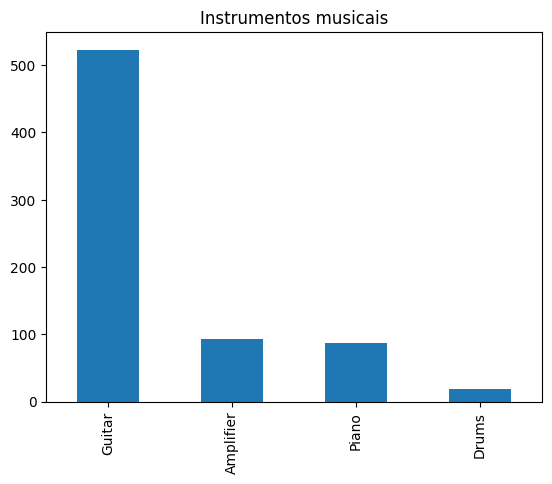

In [65]:
#Visualizando a proporção de imagens por classe
print((df['class']).value_counts())
instruments_count = df['class'].value_counts().plot.bar(title='Instrumentos musicais')

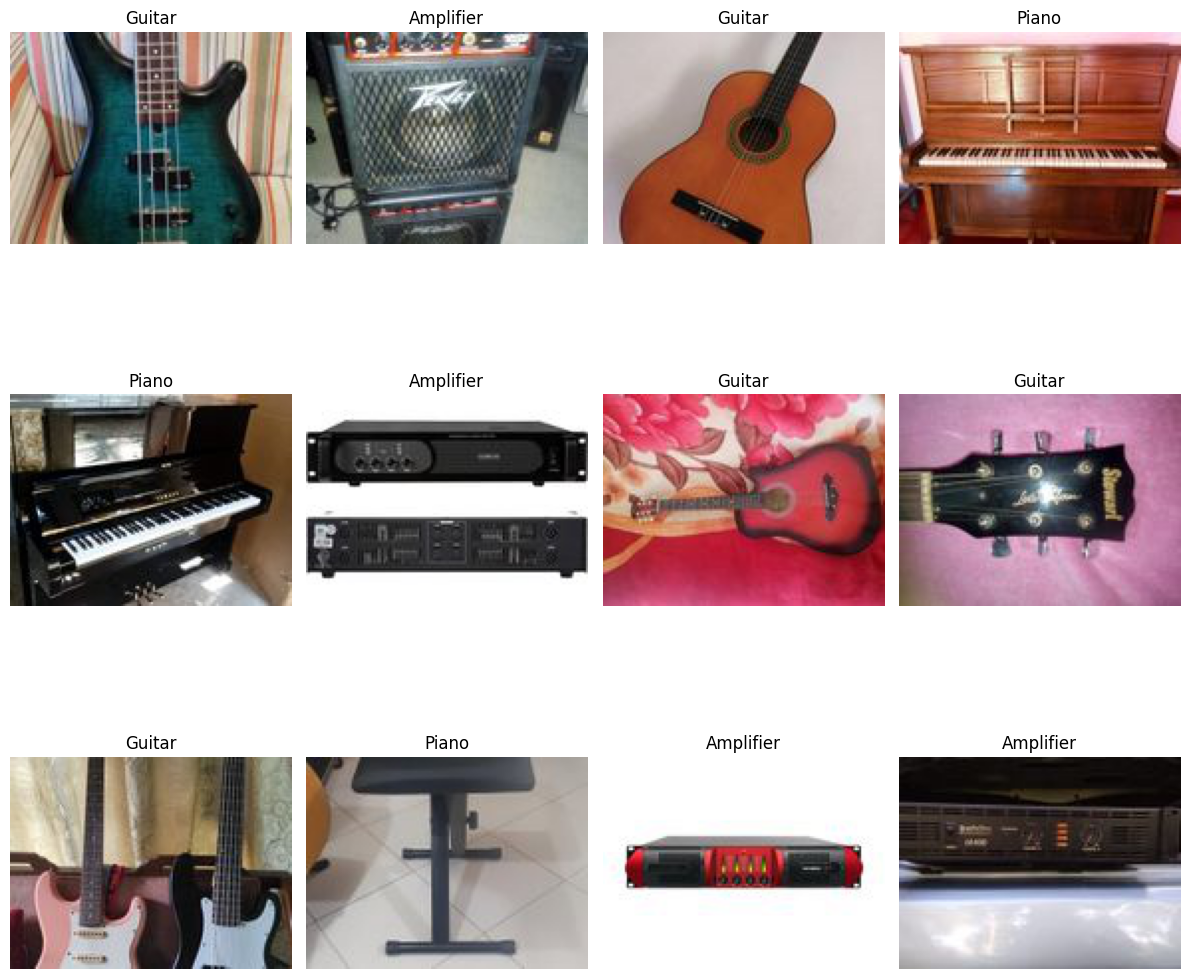

In [66]:
#Visualizando algumas imagens do conjunto de dados
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
df_random = df.sample(frac=1).reset_index(drop=True).head(12)
for i, row in df_random.iterrows():
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    classe = row['class']
    img_name = row['images']
    img_path = os.path.join(path, img_name)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(classe)
plt.tight_layout()
plt.show()

In [67]:
#Dividindo o dataset em 80% para treino e 20% para teste
train, test = train_test_split(df[['images', 'class', 'height', 'width', 'channels', 'filesize']], test_size=0.2, random_state=42, shuffle=True)
#visualizando a divisão dos dados:
print("CONJUNTO DE TREINO")
display(train)
print("CONJUNTO DE TESTE")
display(test)

CONJUNTO DE TREINO


,images,class,height,width,channels,filesize
456,1634111938511_Maverickm310 Box Guitar for sale...,Guitar,107,142,3,3468
6,1634110510622_Line 6 Pod HD X3 Guitar Pedal fo...,Guitar,107,142,3,3340
362,1634112413856_Yamaha U1A Acoustic Piano for sa...,Piano,107,142,3,4473
594,1634117740199_Guitar for sale.jpg,Guitar,107,142,3,3665
439,1634109513457_Guitar wall stand for sale.jpg,Guitar,107,142,3,3643
...,...,...,...,...,...,...
71,1634112181595_Brand New Classical Guitars for ...,Guitar,107,142,3,2460
106,1634110425298_Acoustic Guitar LQ for sale.jpg,Guitar,107,142,3,4957
270,1634111121525_Aria Pro Magna Series Guitar for...,Guitar,107,142,3,3374
435,1634109944541_Casio Celviano Piano Ap40 for sa...,Piano,107,142,3,4422


CONJUNTO DE TESTE


,images,class,height,width,channels,filesize
336,1634111751026_Guitar Yamaha C30 for sale.jpg,Guitar,107,142,3,3024
516,1634110842140_NUX Cerberus Multi Function Guit...,Guitar,107,142,3,4854
552,1634112456643_Bass Guitar Amplifier for sale.jpg,Amplifier,107,142,3,4916
33,1634112410637_Cristofori Acoustic Piano for sa...,Piano,107,142,3,3917
558,1634113172523_Japan Used Box Guitar for sale.jpg,Guitar,107,142,3,3814
...,...,...,...,...,...,...
381,1634113317008_Mixer with Amplifier for sale.jpg,Amplifier,107,142,3,3790
328,1634111717580_Yamaha Bass Guitar for sale.jpg,Guitar,107,142,3,4104
375,1634111801415_Pearl River Piano for sale.jpg,Piano,107,142,3,3945
428,1634112046180_Roland Drums for sale.jpg,Drums,107,142,3,5921


# Preparação dos dados

ImageDataGenerator é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo.

Utilizamos ainda o ImageDataGenerator para separar um conjunto de validação com 20% das amostras do conjunto de treino. É importante que o conjunto de validação não contenha as imagens de teste, tendo em vista que elas não deveriam ser conhecidas no momento do treinamento.

Veja que neste caso é usado o método flow_from_dataframe() para gerar imagens aumentadas a partir de um dataframe que aponta para as imagens originais. O método recebe parâmetros como o dataframe, o diretório com as imagens, o tamanho do lote (batch size) e o modo de classe (neste caso, binário porque são apenas duas classes), entre outros.

Importante ressaltar que o pré-processamento do teste não evolve o aumento de dados.

In [68]:
train_datagen=ImageDataGenerator(validation_split=0.2, #include validation split
                                 rescale = 1.0/255,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    train, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class')

Found 462 validated image filenames belonging to 4 classes.
Found 115 validated image filenames belonging to 4 classes.
Found 145 validated image filenames belonging to 4 classes.


Visualizando um exemplo do tratamento das imagens

Found 1 validated image filenames belonging to 1 classes.


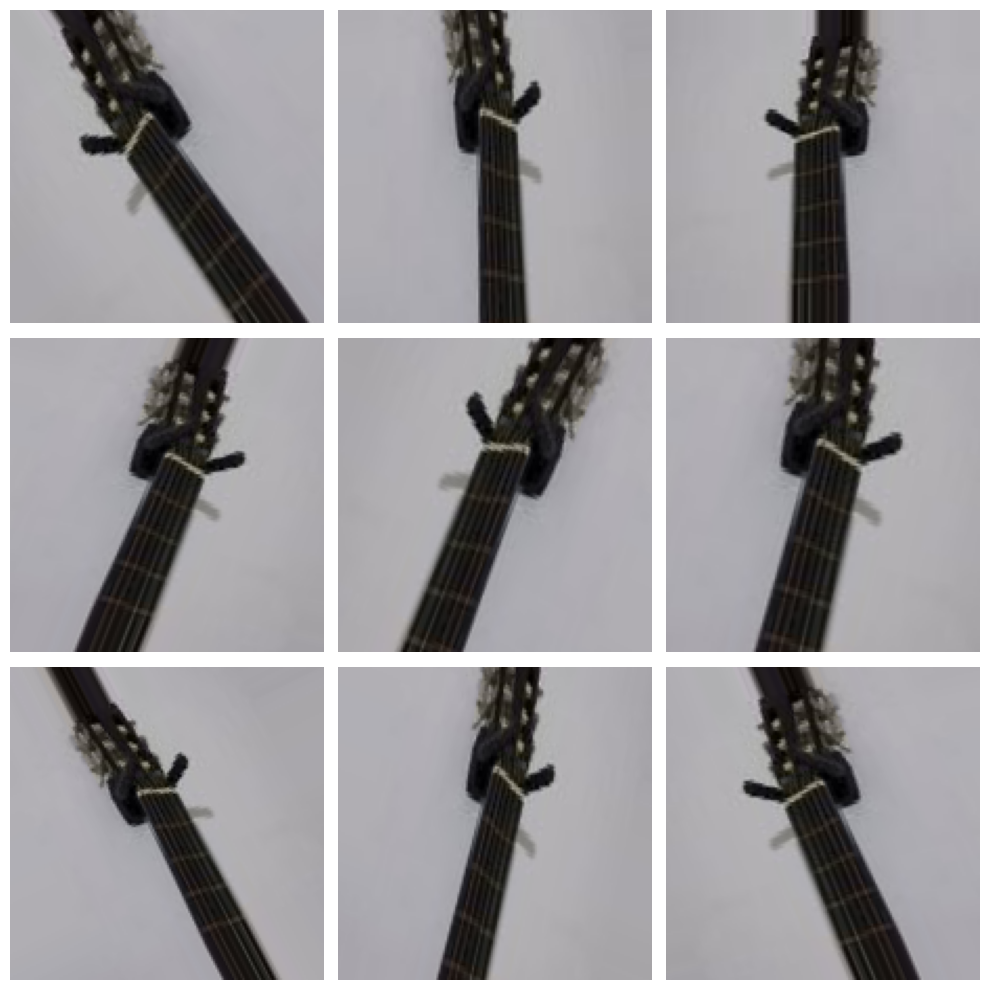

In [69]:
# Pegando um registro do dataframe
sample = df.sample(n=1)

# Neste caso o tipo de classe é categorico, pois temos um exemplo com apenas uma classe
sample_generator = train_datagen.flow_from_dataframe(
    sample,
    path,
    x_col='images',
    y_col='class',
    target_size=(150,150),
    class_mode='categorical'
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

# Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras

Definição da arquitetura do modelo
Aqui é especificada uma camada convolucional 2D que possui 32 filtros, um tamanho de filtro de 3x3 que usa a função de ativação ReLU. O parâmetro input_shape define a forma das imagens de entrada para a rede. Na sequência são adicionadas camadas max-pooling com a mesma função de ativação.

In [70]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

# Treinamento do modelo de deep learning

Compilação do modelo Keras com as configurações do treinamento
optimizer='adam': especifica o otimizador a ser usado durante o treinamento.

loss='binary_crossentropy': especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação binária, onde a variável alvo tem apenas duas categorias, a perda binária de entropia cruzada é freqüentemente empregada.

metrics=['accuracy']: especifica as métricas de avaliação a serem usadas durante o treinamento e o teste.

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

O método fit_generator() inicia o processo de treinamento do modelo usando o gerador de dados para o treinamento train_generator e o gerador de dados de validação val_generator.

In [ ]:
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/20
10/10 [==============================] - 34s 3s/step - loss: 0.9382 - accuracy: 0.6667 - val_loss: 0.7864 - val_accuracy: 0.7652
Epoch 2/20
10/10 [==============================] - 31s 3s/step - loss: 0.7951 - accuracy: 0.7294 - val_loss: 0.6621 - val_accuracy: 0.7652
Epoch 3/20
10/10 [==============================] - 30s 3s/step - loss: 0.7401 - accuracy: 0.7294 - val_loss: 0.6520 - val_accuracy: 0.7652
Epoch 4/20
10/10 [==============================] - 29s 3s/step - loss: 0.6926 - accuracy: 0.7446 - val_loss: 0.6107 - val_accuracy: 0.7565
Epoch 5/20
10/10 [==============================] - 28s 3s/step - loss: 0.6566 - accuracy: 0.7468 - val_loss: 0.5658 - val_accuracy: 0.7652
Epoch 6/20
10/10 [==============================] - 34s 3s/step - loss: 0.6561 - accuracy: 0.7641 - val_loss: 0.5414 - val_accuracy: 0.7739
Epoch 7/20
10/10 [==============================] - 33s 4s/step - loss: 0.6076 - accuracy: 0.7857 - val_loss: 0.5311 - val_accuracy: 0.7913
Epoch 8/20
10/10 [==

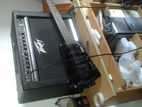

1/1 [==============================] - 0s 99ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9178362




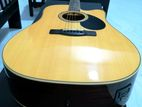

1/1 [==============================] - 0s 36ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9637561




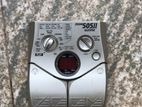

1/1 [==============================] - 0s 34ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.8603112




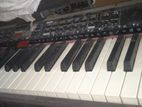

1/1 [==============================] - 0s 37ms/step
True Label: Piano
Prediction: Drums
Probability: 0.4530712




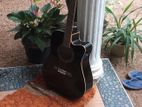

1/1 [==============================] - 0s 36ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.82925993




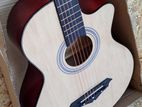

1/1 [==============================] - 0s 61ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.95122457




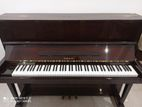

1/1 [==============================] - 0s 41ms/step
True Label: Piano
Prediction: Drums
Probability: 0.9019778




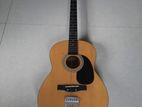

1/1 [==============================] - 0s 36ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.92311186




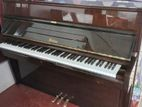

1/1 [==============================] - 0s 37ms/step
True Label: Piano
Prediction: Drums
Probability: 0.5115029




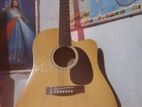

1/1 [==============================] - 0s 36ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.8782501




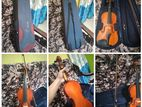

1/1 [==============================] - 0s 35ms/step
True Label: Violin
Prediction: Violin
Probability: 0.90716606




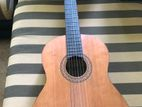

1/1 [==============================] - 0s 41ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.88084674




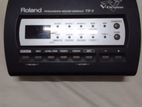

1/1 [==============================] - 0s 38ms/step
True Label: Drums
Prediction: Violin
Probability: 0.86957407




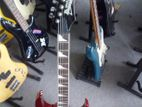

1/1 [==============================] - 0s 39ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.70576495




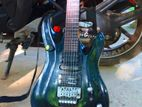

1/1 [==============================] - 0s 39ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.86202914




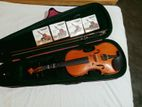

1/1 [==============================] - 0s 41ms/step
True Label: Violin
Prediction: Violin
Probability: 0.70606935




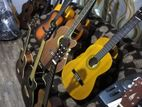

1/1 [==============================] - 0s 35ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.8127949




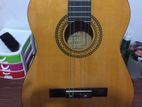

1/1 [==============================] - 0s 40ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.65992594




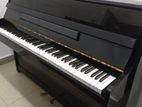

1/1 [==============================] - 0s 34ms/step
True Label: Piano
Prediction: Drums
Probability: 0.72278184




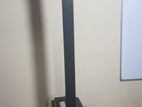

1/1 [==============================] - 0s 37ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.94529665




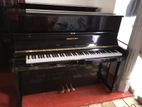

1/1 [==============================] - 0s 34ms/step
True Label: Piano
Prediction: Violin
Probability: 0.51877505




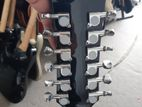

1/1 [==============================] - 0s 37ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9409455




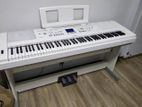

1/1 [==============================] - 0s 35ms/step
True Label: Piano
Prediction: Violin
Probability: 0.83298624




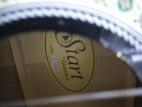

1/1 [==============================] - 0s 39ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.79472744




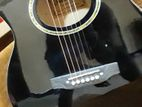

1/1 [==============================] - 0s 36ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.95724034




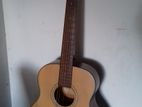

1/1 [==============================] - 0s 34ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.93263334




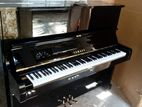

1/1 [==============================] - 0s 38ms/step
True Label: Piano
Prediction: Drums
Probability: 0.8953136




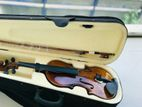

1/1 [==============================] - 0s 41ms/step
True Label: Violin
Prediction: Violin
Probability: 0.98699236




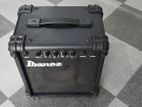

1/1 [==============================] - 0s 33ms/step
True Label: Guitar
Prediction: Drums
Probability: 0.40248144




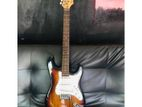

1/1 [==============================] - 0s 34ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.52425367




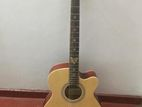

1/1 [==============================] - 0s 45ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9687053




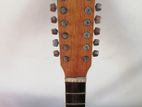

1/1 [==============================] - 0s 42ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.89240927




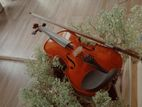

1/1 [==============================] - 0s 64ms/step
True Label: Violin
Prediction: Violin
Probability: 0.7969476




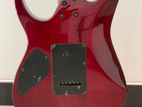

1/1 [==============================] - 0s 59ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.7053869




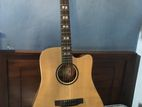

1/1 [==============================] - 0s 63ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.906205




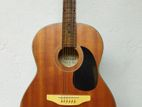

1/1 [==============================] - 0s 57ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.94191253




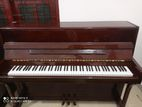

1/1 [==============================] - 0s 69ms/step
True Label: Piano
Prediction: Drums
Probability: 0.73058295




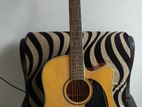

1/1 [==============================] - 0s 55ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.8661279




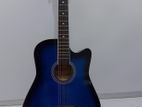

1/1 [==============================] - 0s 60ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9918234




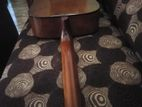

1/1 [==============================] - 0s 59ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.53414726




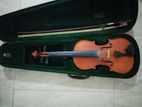

1/1 [==============================] - 0s 65ms/step
True Label: Violin
Prediction: Drums
Probability: 0.75723976




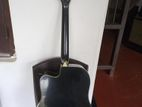

1/1 [==============================] - 0s 53ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9527321




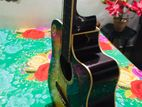

1/1 [==============================] - 0s 54ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.7460745




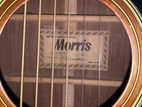

1/1 [==============================] - 0s 56ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.9255335




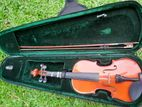

1/1 [==============================] - 0s 60ms/step
True Label: Violin
Prediction: Violin
Probability: 0.51998866




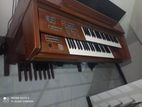

1/1 [==============================] - 0s 60ms/step
True Label: Piano
Prediction: Drums
Probability: 0.73535573




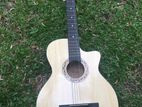

1/1 [==============================] - 0s 62ms/step
True Label: Guitar
Prediction: Violin
Probability: 0.6887902




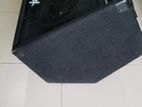

1/1 [==============================] - 0s 57ms/step
True Label: Guitar
Prediction: Drums
Probability: 0.38085327




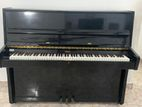

1/1 [==============================] - 0s 58ms/step
True Label: Piano
Prediction: Drums
Probability: 0.8574629




In [41]:
count = 0
class_names = ['Guitar', 'Amplifier', 'Drums', 'Piano']
y_pred = []
y_true = []
column_names=['images', 'class', 'height', 'width', 'channels', 'filesize']
df_test_gen = pd.DataFrame(test, columns=column_names)
for i, row in df_test_gen.iterrows():
    count += 1

    if count == 50:
        break
    else:
        images = row['images']
        labels = row['class']
        y_true.append(labels)
        img_path = os.path.join(path, images)
        img = image.load_img(img_path, target_size=(150, 150))
        display(Image(filename=img_path, width=300))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x.astype('float32') / 255.0
        prediction = model.predict(x)
        predicted_class = np.argmax(prediction[0])
        probability = prediction[0][predicted_class]
        y_pred.append(class_names[predicted_class])
        print("True Label:", labels)
        print("Prediction:", class_names[predicted_class])
        print("Probability:", probability)
        print("\n")







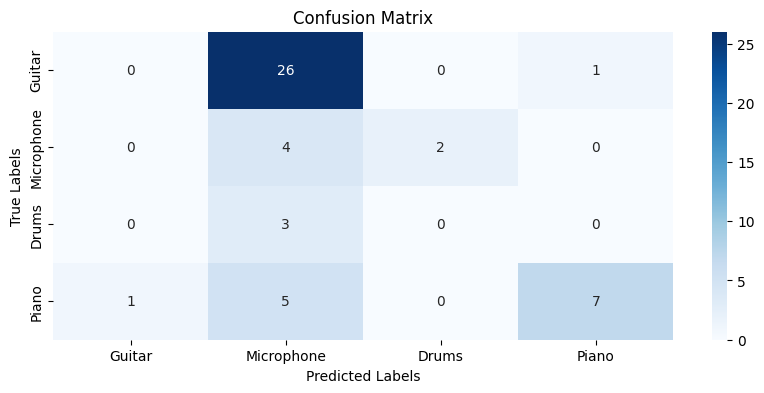

In [22]:
#imprimindo a matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Crie a matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=class_names)

# Exiba a matriz de confusão usando um heatmap do Seaborn
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()